From article https://towardsdatascience.com/whats-inside-a-neural-network-799daf235463

In [21]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

from tqdm import tqdm
import time
from collections import OrderedDict
import warnings

warnings.filterwarnings('ignore')

# Prepare Dataset

The dataset:
$y=\begin{cases}
2x+5, x<-2 \\
7.3 \sin(x), -2\le x<2 \\
-0.03x^3+2, x \ge 2
\end{cases}
$

In [22]:
np.random.seed(42)
X = np.random.normal(1, 4.5, 10000)
y = np.piecewise(
    X,
     [X < -2,(X >= -2) & (X < 2), X >= 2],
      [lambda X: 2*X + 5, lambda X: 7.3*np.sin(X), lambda X: -0.03*X**3 + 2]
    ) + np.random.normal(0, 1, X.shape)

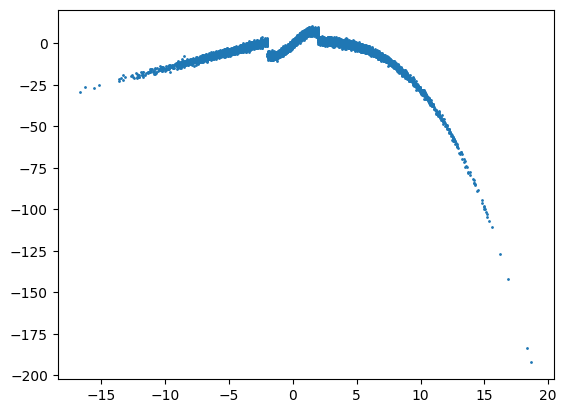

In [24]:
plt.scatter(X, y, s=1)

see also https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [28]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, Y):
    self.x = torch.tensor(X)
    self.y = torch.tensor(Y)
    self.len = self.x.shape[0]

  def __len__(self):
    return self.len

  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

see also https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [30]:
batch_size = 128
train = Dataset(X_train.astype(np.float32), y_train.astype(np.float32))
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size)

test = Dataset(X_test.astype(np.float32), y_test.astype(np.float32))
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size)

# Neural Network

In [16]:
# a toy NN
class ANN(nn.Module):
  def __init__(self, in_features=128, hidden_dim=128, out_features=1):
    super().__init__()
    self.net = nn.Sequential(OrderedDict({
        "Layer_1": nn.Linear(in_features, hidden_dim, bias=False),
        "tahn": nn.Tanh(),
        "Layer_2": nn.Linear(hidden_dim, out_features, bias=False)
    }))

  def forward(self, x):
    return self.net(x)

In [44]:
model = ANN(1, 1, 1)
loss = nn.MSELoss()
model

ANN(
  (net): Sequential(
    (Layer_1): Linear(in_features=1, out_features=1, bias=False)
    (tahn): Tanh()
    (Layer_2): Linear(in_features=1, out_features=1, bias=False)
  )
)

In [45]:
for name, param in model.named_parameters():
  print(name, param.shape)
  print(param)

net.Layer_1.weight torch.Size([1, 1])
Parameter containing:
tensor([[-0.4649]], requires_grad=True)
net.Layer_2.weight torch.Size([1, 1])
Parameter containing:
tensor([[0.0835]], requires_grad=True)


In [46]:
model.net._modules['Layer_1'].weight, model.net._modules['Layer_1'].weight.data

(Parameter containing:
 tensor([[-0.4649]], requires_grad=True),
 tensor([[-0.4649]]))

# Create the grid
To build the error surface, we first need to create a grid of possible values for W1 and W2. Then, for each weight combination, we will update the parameters of the network and calculate the error: